In [104]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

import time
from datetime import datetime
from tqdm.auto import tqdm

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as MSE

import fftoptionlib as fft
import QuantLib as ql

In [106]:
msft_calls = pd.read_pickle("data/msft_calls.pickle")
msft_puts = pd.read_pickle("data/msft_puts.pickle")
expirations = pd.read_pickle("data/expirations.pickle")

msft_stock_price = 294.3900146484375
evaluation_date = '2022-03-16'
maturities = np.array([
    (datetime.strptime(expiration, '%Y-%m-%d') - 
    (datetime.strptime(evaluation_date, '%Y-%m-%d') if evaluation_date else datetime.today())).days / 256 
    for expiration in expirations
])

ql.Settings.instance().evaluationDate = ql.Date(16, 3, 2022)

In [50]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [51]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

In [52]:
def plot_opt_prices(
    strikes, 
    opt_prices, 
    expirations,
    stock_price=msft_stock_price, 
    title=''
):
    if opt_prices.shape[0] == len(expirations):
        opt_prices = opt_prices.T
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.plot(
        np.repeat(strikes[:,None], len(expirations), 1), 
        opt_prices, 
        marker='.',
        label=expirations
    )
    plt.axvline(stock_price, c='red', linestyle='--', label='Stock price')
    plt.legend(title='Expiration date', framealpha=0.5)
    plt.xlabel('Stike, $')
    plt.ylabel('Option price, $')
    plt.show()

# Call options

In [125]:
# рассматриваемые maturities 
df_lens = np.array([len(df) for df in msft_calls])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_calls = [msft_calls[i] for i in indxs]
expirations = [expirations[i] for i in indxs]
maturities = maturities[indxs]
len(msft_calls), len(expirations), len(maturities)

(12, 12, 12)

In [126]:
strikes = msft_calls[0].strike
for row in msft_calls:
  strikes = np.intersect1d(strikes, row.strike)
set_strikes = set(strikes)
print(len(strikes))

33


In [127]:
opt_prices = np.array([(df.bid + df.ask)[df.strike.isin(strikes)] / 2 for df in msft_calls])
opt_prices[np.isnan(opt_prices)] = 3.5e-2
opt_prices.shape

(12, 33)

In [128]:
vols = np.array([df.impliedVolatility.loc[df.strike.isin(strikes)] for df in msft_calls])
vols.shape

(12, 33)

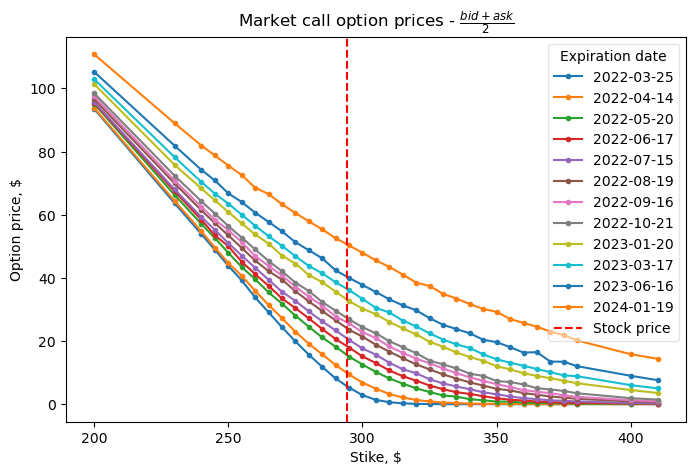

In [57]:
plot_opt_prices(strikes, opt_prices, expirations, title=r'Market call option prices - $\frac{bid + ask}{2}$')

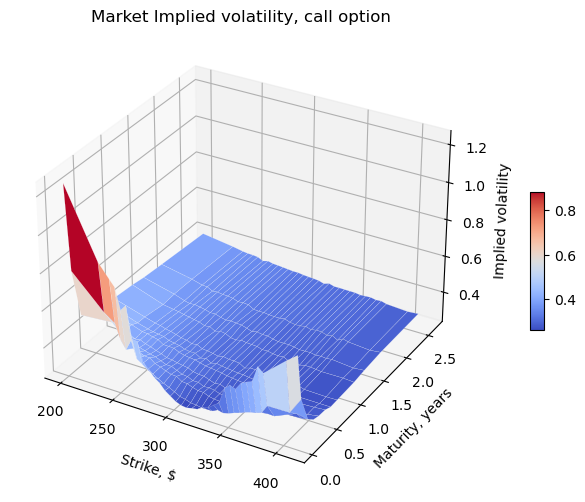

In [58]:
plot_surface(strikes, maturities, vols, 'Market Implied volatility, call option')

## SABR

In [123]:
class SABR:
    
    def __init__(self, stock_price=msft_stock_price):
        self.stock_price = stock_price
        self.params = []
    
    @staticmethod
    def volatility(strikes, stock_price, t, alpha, beta, rho, nu):
        f = stock_price
        K = strikes
        z = nu / alpha * (f*K)**((1-beta)/2) * np.log(f/K)
        x = np.log(((1-2*rho*z+z**2)**0.5 + z - rho)/(1-rho))
        first = alpha / ((f*K)**((1-beta)/2) * (1+(1-beta)**2 / 24 * 
                (np.log(f/K))**2 + (1-beta)**4 / 1920 * (np.log(f/K))**4))
        second = z/x
        third = 1 + t*((1-beta)**2 / 24 *  alpha**2 / ((f*K)**(1-beta)) + 
                (rho*beta*nu*alpha)/(4*(f*K)**((1-beta)/2)) + nu**2*(2-3*rho**2)/24)
        return first * second * third

    def fit(self, strikes, mrkt_vols, expiration:float, frac_ootm=1, frac_itm=1):
        
        def RSS_SABR(params, t, stock_price):
            sabr_vols = self.volatility(strikes, stock_price, t, *params)
            return np.sum(np.square(sabr_vols - mrkt_vols))
        
        strikes = np.array(strikes)
        mrkt_vols = np.array(mrkt_vols)

        if frac_ootm < 1 and frac_itm < 1:
            nearest = np.argmin(np.abs(strikes-self.stock_price))
            
            mask_relevant = np.repeat(False, len(strikes))
            rel_ootm = int(frac_ootm * len(strikes) / 2)
            rel_itm = int(frac_itm * len(strikes) / 2)
            mask_relevant[nearest-rel_itm : nearest+rel_ootm+1] = True
            
            strikes = strikes[mask_relevant]
            mrkt_vols = mrkt_vols[mask_relevant]

        # alpha, beta, rho, nu
        min_args = (expiration, self.stock_price)
        x0 = [0.001, 1, -0.999, 0.001]
        bounds = ((0.001, None), (1, 1), (-0.999, 0.999), (0.001, None))
        res = minimize(RSS_SABR, x0, min_args, bounds=bounds)
        self.params.append(res.x)

    def iv_surface(self, strikes, expirations, params=None):
        if params is None:
            params = self.params
        surface = np.zeros((len(expirations), len(strikes)), dtype=float)
        for i, (t,p) in enumerate(zip(expirations, params)):
            surface[i,:] = self.volatility(strikes, self.stock_price, t, *p) 
        
        return surface

    def MSE_all(self, df_list, expirations, params=None):
        if params is None:
            params = self.params
        
        sse = 0
        cnt = 0
        for i, (t,df,p) in enumerate(zip(expirations, df_list, params)):
            cnt += len(df)
            sabr_vols = self.volatility(df.strike, self.stock_price, t, *p)
            sse += np.sum(np.square(sabr_vols - df.impliedVolatility))

        return sse / cnt


In [60]:
%%time
sabr = SABR(msft_stock_price)

sabr_times = []
for i, t, in enumerate(tqdm(maturities)):
    start = time.time()
    sabr.fit(strikes, vols[i,:], t)
    end = time.time()
    sabr_times.append(end-start)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: total: 31.2 ms
Wall time: 94.2 ms


In [61]:
print(f'SABR calibration time {np.sum(sabr_times):0.5f} sec.')

SABR calibration time 0.08622 sec.


In [62]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
sabr_surface = sabr.iv_surface(strikes_net, maturities)

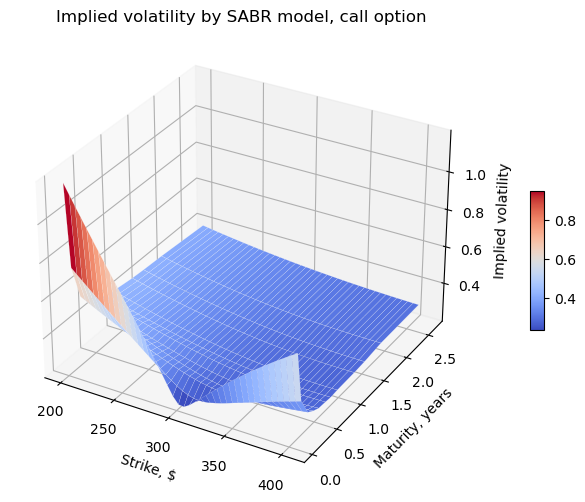

In [63]:
plot_surface(strikes_net, maturities, sabr_surface, 'Implied volatility by SABR model, call option')

### Train MSE

In [96]:
%%timeit
sabr_train_vols = sabr.iv_surface(strikes, maturities)

371 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [65]:
MSE(vols, sabr_train_vols)

0.00019039910127382313

### All MSE

In [66]:
sabr.MSE_all(msft_calls, maturities)

0.02379910750030042

### Option prices

In [67]:
sabr_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, sabr_train_vols)
MSE(opt_prices, sabr_opt_prices)

163.94655655338562

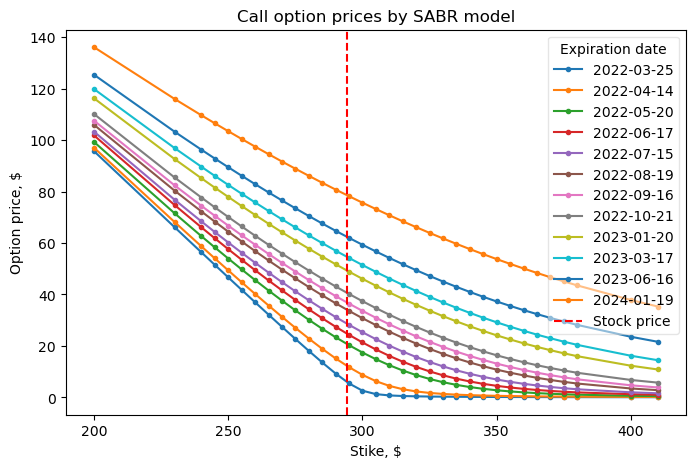

In [68]:
plot_opt_prices(strikes, sabr_opt_prices, expirations, title='Call option prices by SABR model')

## Heston

In [69]:
class Heston(ql.HestonModel):
    
    def __init__(
        self, 
        init_params=(0.01, 1, 0.5, 0, 0.1), 
        bounds=[(0,1), (0.01,15), (0.01,None), (-1,1), (0,1.0) ],
        q=0.0, 
        r=0.05, 
        evaluation_date='2022-03-16',
        spot=msft_stock_price
    ):
        self.init_params = init_params
        self.bounds = bounds
        theta, kappa, sigma, rho, v0 = self.init_params
        self.spot = spot
        self.calculation_date = ql.Date(evaluation_date, '%Y-%m-%d')
        day_count = ql.Actual365Fixed() 
        self.calendar = ql.UnitedStates(1)
        self.yield_ts = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, r, day_count)
        )
        self.dividend_ts = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, q, day_count)
        )
        process = ql.HestonProcess(
            self.yield_ts, self.dividend_ts, 
            ql.QuoteHandle(ql.SimpleQuote(spot)), 
            v0, kappa, theta, sigma, rho
        )
        super().__init__(process)
        self.engine = ql.AnalyticHestonEngine(self)
        self.vol_surf = ql.HestonBlackVolSurface(ql.HestonModelHandle(self), self.engine.Gatheral)
        # self.build_helpers()
        

    def build_helpers(self, expirations, strikes, vols):
        maturities = [
            ql.Period(ql.Date(expir, '%Y-%m-%d') - self.calculation_date, ql.Days)
             for expir in expirations
        ]
        temp=[]
        for m,v in zip(maturities,vols):
            for i,s in enumerate(strikes):
                temp.append( 
                    ql.HestonModelHelper(
                        m, self.calendar, self.spot, s, 
                        ql.QuoteHandle(ql.SimpleQuote(v[i])), 
                        self.yield_ts, self.dividend_ts
                    )  
                )
        for x in temp: x.setPricingEngine(self.engine)
        self.helpers=temp
        self.loss= [x.calibrationError() for x in self.helpers]


    def f_cost(self, params, strikes, mrkt_vols, expirations, norm=False):
        self.setParams( ql.Array(list(params)) )
        self.build_helpers(expirations, strikes, mrkt_vols)
        if norm == True:
            loss = np.array(self.loss)
            mask = np.isinf(loss) | np.isnan(loss)
            self.loss = np.mean(np.square(loss[~mask]))
        return self.loss


    def fit(self, strikes, mrkt_vols, expirationsm, method='L-BFGS-B'):
        # self.build_heplers(expirations, strikes, mrkt_vols)
        if method == 'L-BFGS-B':
            min_args = (strikes, mrkt_vols, expirations, True)
            res = minimize(
                self.f_cost, self.init_params, 
                args=min_args, 
                method='L-BFGS-B', 
                bounds=self.bounds
            )
            self.params = res.x
        elif method == 'LM':
            self.build_helpers(expirations, strikes, mrkt_vols)
            self.calibrate(
                self.helpers, 
                ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8),
                ql.EndCriteria(500, 300, 1.0e-8,1.0e-8, 1.0e-8)
            )


    def iv_surface(self, strikes, maturities):
        surface = np.zeros((len(maturities), len(strikes)), dtype=float)
        for i,t in enumerate(maturities):
            surface[i,:] = np.array([self.vol_surf.blackVol(t,s) for s in strikes])
        
        return surface

    def MSE_all(self, df_list, maturities):
        sse = 0
        cnt = 0
        for i, (t, df) in enumerate(zip(maturities, df_list)):
            cnt += len(df)
            heston_vols = np.array([self.vol_surf.blackVol(t,s) for s in df.strike])
            sse += np.sum(np.square(heston_vols - df.impliedVolatility))

        return sse / cnt

    # def get_option_obj(
    #     self,
    #     expiration_date : str,
    # ):  
    #     """Build `fftoptionlib` Option object 

    #     Args:
    #         expiration_date (str): expiration date in format '%Y-%m-%d'
    #         q (float): dividend rate
    #         r (float): risk-free rate

    #     Returns:
    #         vanilla_option : `fftoptionlib` Option object
    #     """
    #     vanilla_option = fft.BasicOption()
    #     (vanilla_option.set_underlying_close_price(self.spot)
    #         .set_dividend(self.q)
    #         .set_maturity_date(expiration_date)
    #         .set_evaluation_date(self.evaluation_date)
    #         .set_zero_rate(self.r))

    #     return vanilla_option


In [98]:
%%time
heston = Heston()
heston.fit(strikes, vols, expirations, method='L-BFGS-B')

CPU times: total: 4.23 s
Wall time: 15.4 s


In [71]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
heston_surface = heston.iv_surface(strikes_net, maturities)

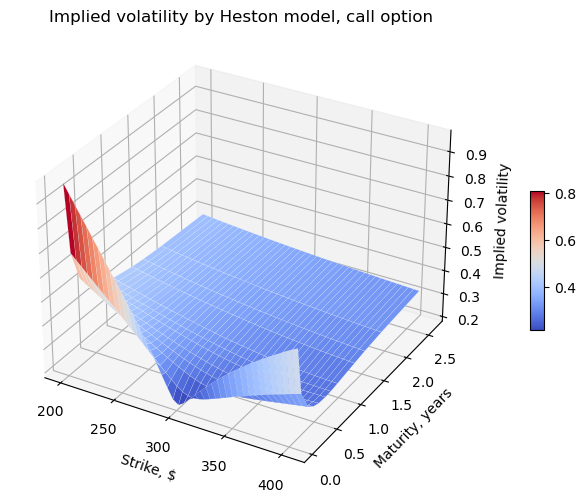

In [72]:
plot_surface(strikes_net, maturities, heston_surface, 'Implied volatility by Heston model, call option')

### Train MSE

In [73]:
%%time
heston_train_vols = heston.iv_surface(strikes, maturities)

CPU times: total: 0 ns
Wall time: 27.9 ms


In [74]:
MSE(vols, heston_train_vols)

0.0010056552071820277

### All MSE

In [75]:
heston.MSE_all(msft_calls, maturities)

0.024879284050507308

### Option prices

In [76]:
heston_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)

for i,t in enumerate(tqdm(expirations)):
    exercise = ql.EuropeanExercise(ql.Date(t, '%Y-%m-%d'))
    for j,K in enumerate(strikes):
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
        option = ql.EuropeanOption(payoff, exercise)
        option.setPricingEngine(heston.engine)
        heston_opt_prices[i,j] = option.NPV()

MSE(opt_prices, heston_opt_prices)

  0%|          | 0/12 [00:00<?, ?it/s]

44.30301289769421

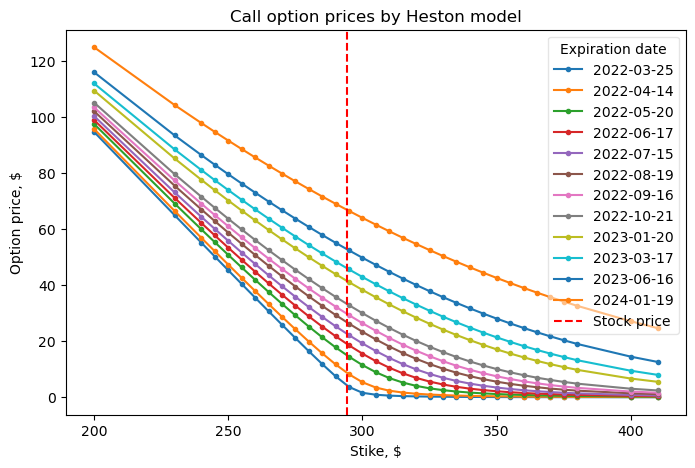

In [77]:
plot_opt_prices(strikes, heston_opt_prices, expirations, title='Call option prices by Heston model')

## Variance-Gamma

In [78]:
class Variance_Gamma:
    
    def __init__(self, evaluation_date='2022-03-16', stock_price=msft_stock_price, q=0.0, r=0.05):
        self.evaluation_date = evaluation_date
        ql.Settings.instance().evaluationDate = ql.Date(evaluation_date, '%Y-%m-%d')
        self.params = []
        self.stock_price = stock_price
        self.q = q
        self.r = r

    def get_option_obj(
        self,
        expiration_date : str,
    ):  
        """Build `fftoptionlib` Option object 

        Args:
            expiration_date (str): expiration date in format '%Y-%m-%d'
            q (float): dividend rate
            r (float): risk-free rate

        Returns:
            vanilla_option : `fftoptionlib` Option object
        """
        vanilla_option = fft.BasicOption()
        (vanilla_option.set_underlying_close_price(self.stock_price)
            .set_dividend(self.q)
            .set_maturity_date(expiration_date)
            .set_evaluation_date(self.evaluation_date)
            .set_zero_rate(self.r))

        return vanilla_option


    def get_vg_prices(
        self,
        theta : float,
        v : float,
        sigma : float,
        option_obj,
        strikes, 
    ):
        """Calculates fair option prices using Variance-Gamma model 

        Args:
            theta (float): VG model parameter - drift
            v (float): VG model parameter - variance rate
            sigma (float): VG model parameter - instantaneous volatility
            option_obj : `fftoptionlib` Option object
            strikes : strikes for which needs to calculate prices

        Returns:
            vg_prices : VG-calculated fair option prices
        """
        N=2**15
        d_u = 0.01
        alpha = 1
        ft_pricer = fft.FourierPricer(option_obj)
        (ft_pricer.set_pricing_engine(fft.FFTEngine(N, d_u, alpha, spline_order=2))
            .set_log_st_process(fft.VarianceGamma(theta=theta, v=v, sigma=sigma))
        )

        strikes = np.array(strikes)
        put_call = 'call'

        return ft_pricer.calc_price(strikes, put_call)


    def get_iv_params(
        self,
        expiration_date, 
        strikes,
        sigma_0=0.2,
    ):
        calendar = ql.UnitedStates(1)
        exercise = ql.EuropeanExercise(ql.Date(expiration_date, '%Y-%m-%d'))
        
        S = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        q = ql.YieldTermStructureHandle(ql.FlatForward(0, calendar, self.q, ql.Actual365Fixed()))
        r = ql.YieldTermStructureHandle(ql.FlatForward(0, calendar, self.r, ql.Actual365Fixed()))
        sigma = ql.BlackVolTermStructureHandle(
            ql.BlackConstantVol(0, calendar, sigma_0, ql.Actual365Fixed())
        )

        return exercise, S, q, r, sigma

    def calc_iv(
        self,
        opt_prices, 
        strikes, 
        iv_params,
    ):
        """Calculates implied volatilities from option prices

        Args:
            iv_params (tuple) : exercise, S, q, r, sigma
        """
        ivs = []
        for V, K in zip(opt_prices, strikes):
            payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
            option = ql.EuropeanOption(payoff, iv_params[0])
            process = ql.BlackScholesMertonProcess(*iv_params[1:])
            ivs.append(option.impliedVolatility(V, process))

        return np.array(ivs)


    def fit(
        self,
        expiration_date : str,
        strikes,
        mrkt_vols,
        frac_ootm : float=0.6,
        frac_itm : float=0.6,
    ):

        def RSS(par, mkrt_vols, option_obj, strikes, iv_params):
            theta = par[0]
            v = par[1]
            sigma = par[2]
            vg_prices = self.get_vg_prices(theta, v, sigma, option_obj, strikes)
            vg_pred_iv = self.calc_iv(vg_prices, strikes, iv_params)

            return np.sum(np.square(mkrt_vols - vg_pred_iv))

        strikes = np.array(strikes)
        mrkt_vols = np.array(mrkt_vols)
        
        option_obj = self.get_option_obj(expiration_date)
        iv_params = self.get_iv_params(expiration_date, strikes)
        
        if frac_ootm < 1 and frac_itm < 1:
            nearest = np.argmin(np.abs(strikes-self.stock_price))
            mask_relevant = np.repeat(False, len(strikes))
            rel_ootm = int(frac_ootm * len(strikes) / 2)
            rel_itm = int(frac_itm * len(strikes) / 2)
            mask_relevant[nearest-rel_itm : nearest+rel_ootm+1] = True
        else:
            mask_relevant = np.repeat(True, len(strikes))

        min_args = (mrkt_vols[mask_relevant], option_obj, strikes[mask_relevant], iv_params)
        # theta, v, sigma
        x0 = [0, 0.2, 0.3]
        bounds = ((-1,None), (1e-3,None), (1e-3,None))
        res = minimize(RSS, x0, min_args, bounds=bounds, method='L-BFGS-B')
        self.params.append(res.x)
        # return res.x

    def iv_surface(self, strikes, expirations, params=None):
        if params is None:
            params = self.params

        surface = np.zeros((len(expirations), len(strikes)), dtype=float)
        for i, (expir,p) in enumerate(zip(expirations, params)):
            option_obj = self.get_option_obj(expir)
            iv_params = self.get_iv_params(expir, strikes)
            vg_prices = self.get_vg_prices(*p, option_obj, strikes)
            surface[i,:] = self.calc_iv(vg_prices, strikes, iv_params)
        
        return surface

    def MSE_all(self, df_list, expirations, params=None):
        if params is None:
            params = self.params

        sse = 0
        cnt = 0
        for i, (expir, df, p) in enumerate(zip(expirations, df_list, params)):
            cnt += len(df)

            option_obj = self.get_option_obj(expir)
            iv_params = self.get_iv_params(expir, df.strike)
            vg_prices = self.get_vg_prices(*p, option_obj, df.strike)
            vg_vols = self.calc_iv(vg_prices, df.strike, iv_params)

            sse += np.sum(np.square(vg_vols - df.impliedVolatility))

        return sse / cnt
     

In [79]:
%%time
vg = Variance_Gamma()

vg_times = []
for i, expir in enumerate(tqdm(expirations)):
    start = time.time()
    vg.fit(expir, strikes, vols[i,:])
    end = time.time()
    vg_times.append(end-start)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: total: 4.72 s
Wall time: 16.6 s


In [80]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
vg_surface = vg.iv_surface(strikes_net, expirations)

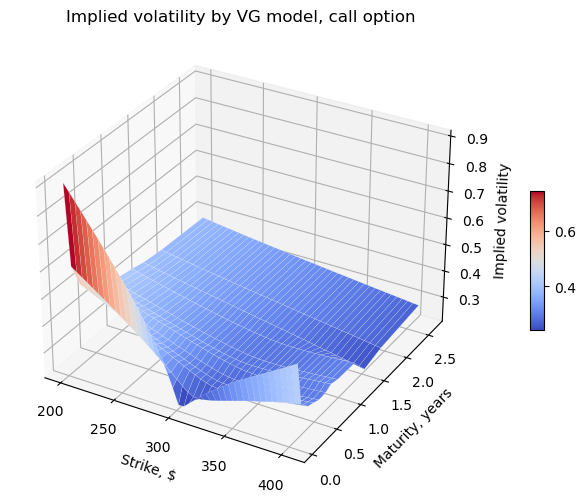

In [81]:
plot_surface(strikes_net, maturities, vg_surface, 'Implied volatility by VG model, call option')

### Train MSE

In [82]:
%%time
vg_train_vols = vg.iv_surface(strikes, expirations)

CPU times: total: 62.5 ms
Wall time: 144 ms


In [83]:
MSE(vols, vg_train_vols)

0.001270818208177892

### All MSE

In [84]:
vg.MSE_all(msft_calls, expirations)

0.026897737630666524

### Option prices


In [85]:
vg_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)
for i, exp in enumerate(tqdm(expirations)):
    option_obj = vg.get_option_obj(exp)
    vg_opt_prices[i] = vg.get_vg_prices(*vg.params[i], option_obj, strikes)

MSE(opt_prices, vg_opt_prices)

  0%|          | 0/12 [00:00<?, ?it/s]

33.138529397527364

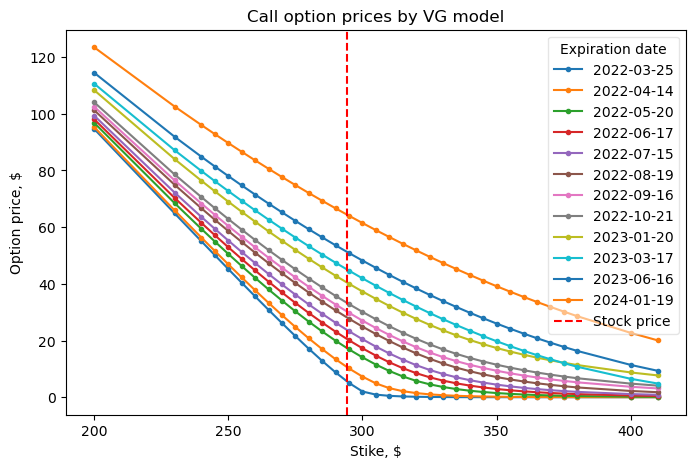

In [86]:
plot_opt_prices(strikes, vg_opt_prices, expirations, title='Call option prices by VG model')

# Near and far MSE

In [87]:
mask1 = maturities <= 1
mask2 = maturities > 1

for mod in ['sabr', 'heston', 'vg']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_opt_prices'][mask2]))

sabr
Near 48.87810459606887
Far 394.0834604680191
heston
Near 8.340900432585793
Far 116.22723782791104
vg
Near 9.017427882823885
Far 81.38073242693432


In [88]:
import pickle
with open('nn_opt_prices_no_opt_prices.pkl', 'rb') as f:
    nn_b_opt_prices = pickle.load(f)

with open('nn_vols_no_opt_prices.pkl', 'rb') as f:
    nn_b_vols = pickle.load(f)

with open('nn_opt_prices_1.pkl', 'rb') as f:
    nn_a_opt_prices = pickle.load(f)

with open('nn_vols_1.pkl', 'rb') as f:
    nn_a_vols = pickle.load(f)

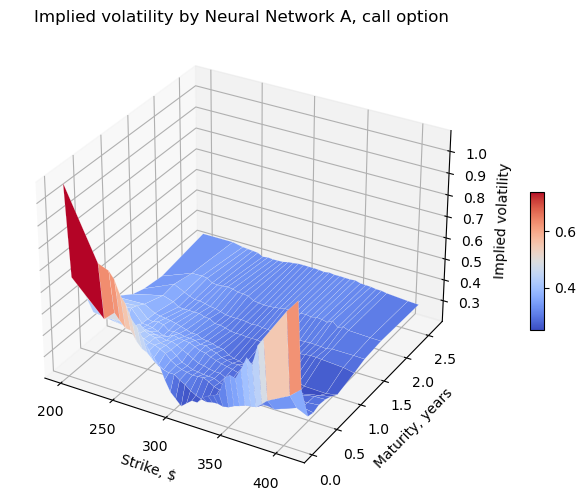

In [100]:
plot_surface(strikes, maturities, nn_a_vols, title='Implied volatility by Neural Network A, call option')

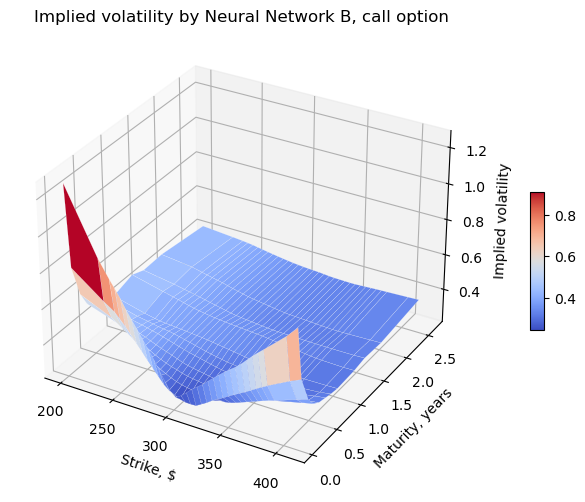

In [101]:
plot_surface(strikes, maturities, nn_b_vols, title='Implied volatility by Neural Network B, call option')

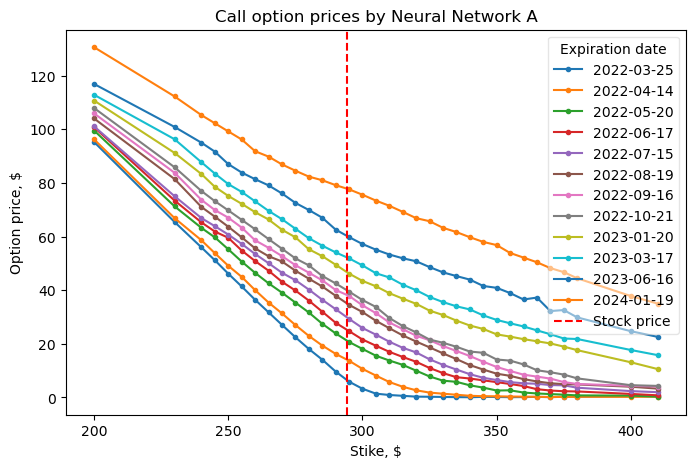

In [102]:
plot_opt_prices(strikes, nn_a_opt_prices, expirations, title='Call option prices by Neural Network A')

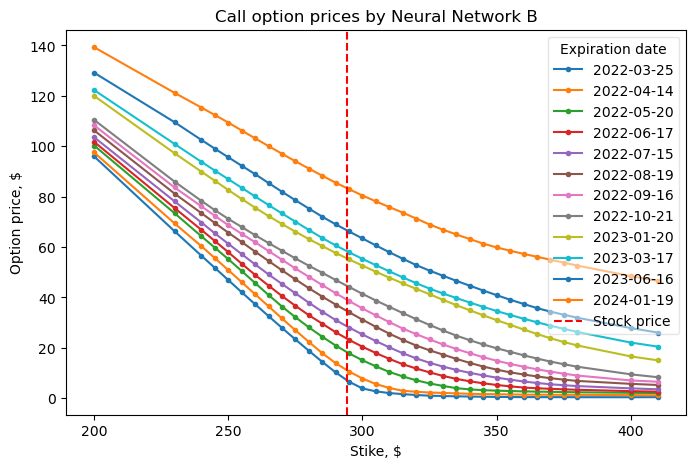

In [103]:
plot_opt_prices(strikes, nn_b_opt_prices, expirations, title='Call option prices by Neural Network B')

In [99]:
for mod in ['nn_a', 'nn_b']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_opt_prices'][mask2]))

nn_a
Near 47.96668626218611
Far 361.31951686071636
nn_b
Near 65.73720819945746
Far 623.530978769823


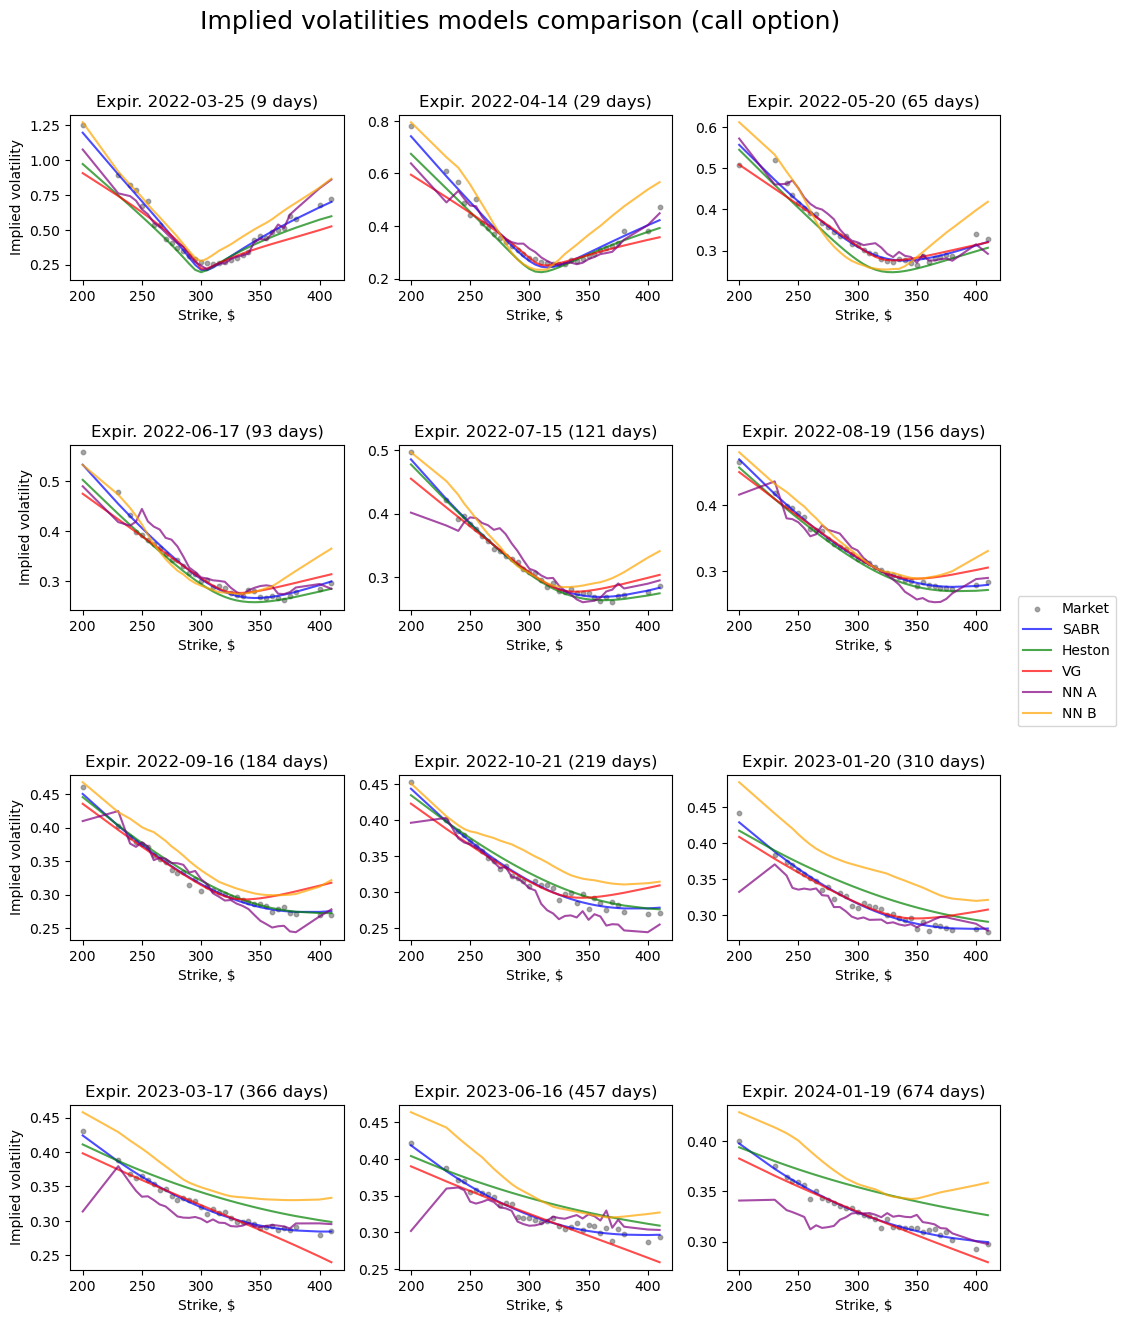

In [89]:

all_ivs = [
    vols,
    sabr_train_vols,
    heston_train_vols,
    vg_train_vols,
    nn_a_vols,
    nn_b_vols
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Implied volatilities models comparison (call option)", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    ax.scatter(strikes, all_ivs[0][i], c=colors[0], label=labels[0], alpha=0.7, s=10)
    # ax.scatter(msft_calls[i].strike, msft_calls[i].impliedVolatility, c=colors[0], label=labels[0], alpha=0.7, s=10)
    for j in range(len(all_ivs)-1):
        ax.plot(strikes, all_ivs[j+1][i], c=colors[j+1], label=labels[j+1], alpha=0.7)
    # ax.get_legend().remove()
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Implied volatility')
    # ax.legend(loc='upper right')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()

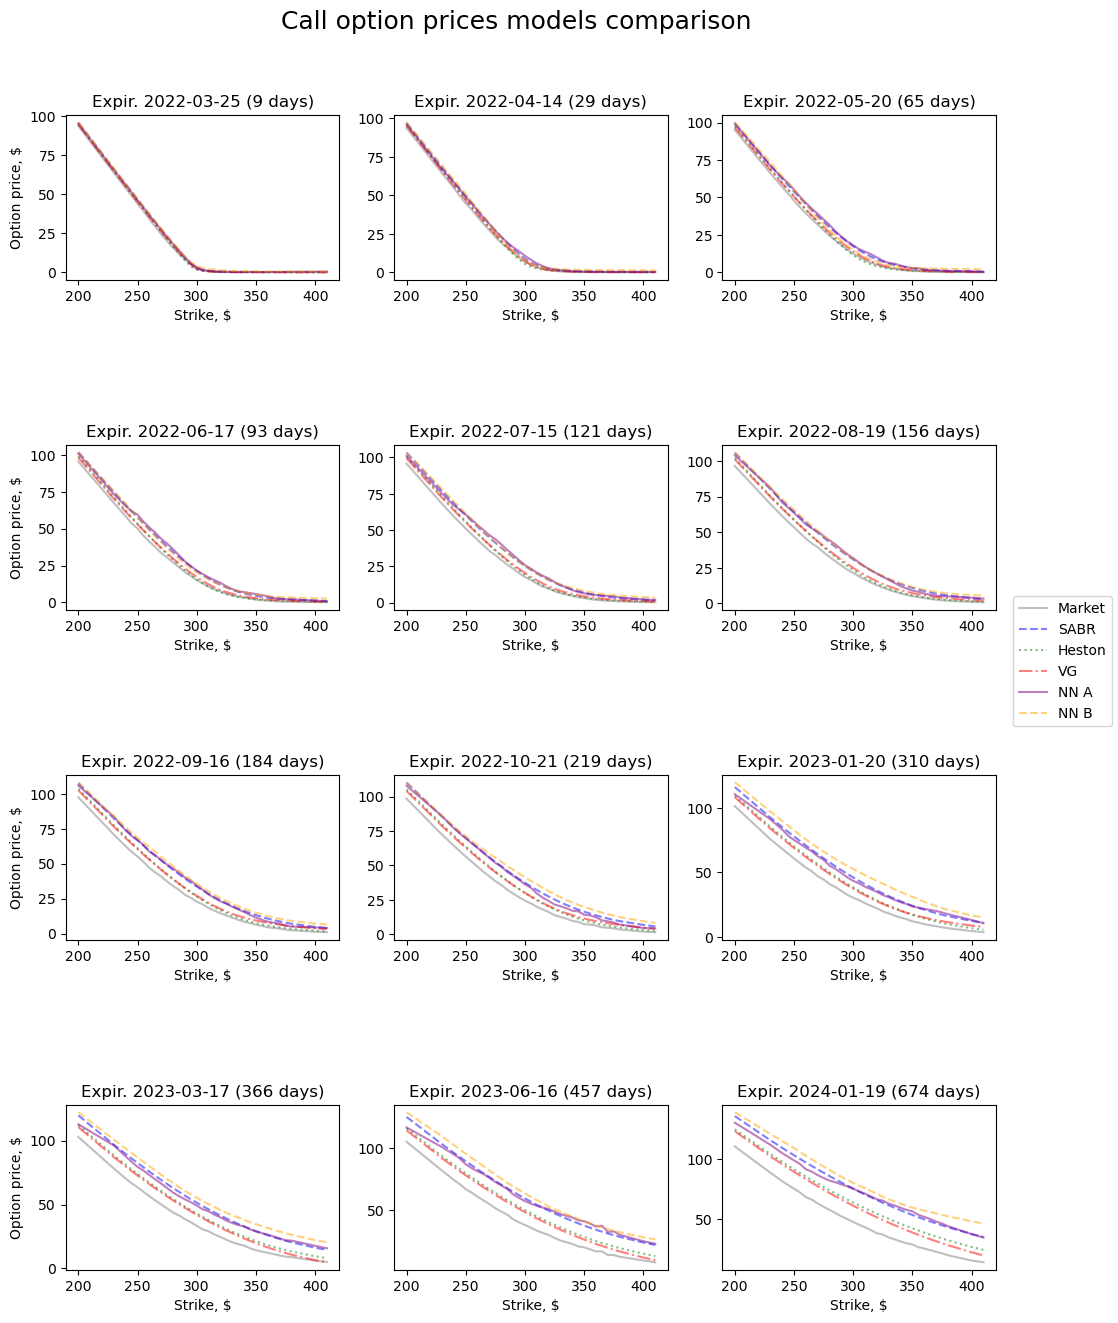

In [90]:
all_prices = [
    opt_prices,
    sabr_opt_prices,
    heston_opt_prices,
    vg_opt_prices,
    nn_a_opt_prices,
    nn_b_opt_prices,
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Call option prices models comparison", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    # ax.scatter(strikes, all_prices[0][i], c=colors[0], label=labels[0], alpha=0.5, s=10)
    for j in range(len(all_prices)):
        ax.plot(strikes, all_prices[j][i], c=colors[j], label=labels[j], alpha=0.5, linestyle=linestyles[j % 4])
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Option price, $')
    # ax.legend(loc='upper right')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()

# Plots

In [91]:
# all_prices = [
#     opt_prices,
#     sabr_opt_prices,
#     heston_opt_prices,
#     vg_opt_prices,
# ]
# labels = ['Market', 'SABR', 'Heston', 'VG']
# colors = ['g', 'b', 'orange', 'r']

# for i, expir in enumerate(expirations):
#     plt.figure(figsize=(8,4))
#     plt.title(f'Call option prices models comparison, expiration date {exp}')
#     for j in range(4):
#         plt.plot(strikes, all_prices[j][i], c=colors[j], label=labels[j])
#     plt.xlabel('Strike, $')
#     plt.ylabel('Option price, $')
#     plt.legend()
#     plt.show()

In [92]:
# all_ivs = [
#     vols,
#     sabr_train_vols,
#     heston_train_vols,
#     vg_train_vols,
# ]
# labels = ['Market', 'SABR', 'Heston', 'VG']
# colors = ['g', 'b', 'orange', 'r']

# for i, expir in enumerate(expirations):
#     plt.figure(figsize=(8,4))
#     plt.title(f'Implied volatilities models comparison, expiration date {exp}')
#     for j in range(4):
#         plt.plot(strikes, all_ivs[j][i], c=colors[j], label=labels[j], alpha=0.4)
#     plt.xlabel('Strike, $')
#     plt.ylabel('Implied volatility')
#     plt.legend()
#     plt.show()

In [93]:
# maturities[5] * 256

In [94]:
# all_ivs = [
#     vols,
#     sabr_train_vols,
#     heston_train_vols,
#     vg_train_vols,
# ]
# labels = ['Market', 'SABR', 'Heston', 'VG']
# colors = ['grey', 'b', 'g', 'r']

# fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
# plt.subplots_adjust(hspace=1)
# fig.suptitle("Implied volatilities models comparison (call option)", fontsize=18, y=0.95)

# for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
#     ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
#     ax.scatter(strikes, all_ivs[0][i], c=colors[0], label=labels[0], alpha=0.7, s=10)
#     # ax.scatter(msft_calls[i].strike, msft_calls[i].impliedVolatility, c=colors[0], label=labels[0], alpha=0.7, s=10)
#     for j in range(3):
#         ax.plot(strikes, all_ivs[j+1][i], c=colors[j+1], label=labels[j+1], alpha=0.5)
#     # ax.get_legend().remove()
#     ax.set_xlabel('Strike, $')
#     ax.set_ylabel('Implied volatility')
#     ax.legend(loc='upper right')
# plt.show()

In [95]:
# all_prices = [
#     opt_prices,
#     sabr_opt_prices,
#     heston_opt_prices,
#     vg_opt_prices,
# ]
# labels = ['Market', 'SABR', 'Heston', 'VG']
# colors = ['grey', 'b', 'g', 'r']

# fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
# plt.subplots_adjust(hspace=1)
# fig.suptitle("Call option prices models comparison", fontsize=18, y=0.95)

# for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
#     ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
#     # ax.scatter(strikes, all_prices[0][i], c=colors[0], label=labels[0], alpha=0.5, s=10)
#     for j in range(4):
#         ax.plot(strikes, all_prices[j][i], c=colors[j], label=labels[j], alpha=0.5)
#     ax.set_xlabel('Strike, $')
#     ax.set_ylabel('Option price, $')
#     ax.legend(loc='upper right')
# plt.show()